In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
X_train = pd.read_csv("training_v2.csv")
unlabeled = pd.read_csv("unlabeled.csv")

X_train.drop(['hospital_id', 'patient_id', 'icu_id', 'readmission_status'], inplace=True, axis=1)
unlabeled.drop(['hospital_id', 'patient_id', 'icu_id', 'readmission_status', 'hospital_death'], 
inplace=True, axis=1)

print(X_train.shape)
print(unlabeled.shape)

(91713, 182)
(39308, 181)


In [3]:
X_train["height"] = np.where((X_train.height.isna() & (X_train.gender == 'F')), 160, X_train["height"])
X_train["height"] = np.where((X_train.height.isna() & (X_train.gender == 'M')), 180, X_train["height"])
X_train["height"] = np.where((X_train.height.isna() & (X_train.gender.isna())), 170, X_train["height"])
X_train["weight"] = np.where((X_train.height.isna() & (X_train.gender == 'F')), 65, X_train["weight"])
X_train["weight"] = np.where((X_train.height.isna() & (X_train.gender == 'M')), 82, X_train["weight"])
X_train["weight"] = np.where((X_train.height.isna() & (X_train.gender.isna())), 74, X_train["weight"])

In [4]:
unlabeled["height"] = np.where((unlabeled.height.isna() & (unlabeled.gender == 'F')), 160, unlabeled["height"])
unlabeled["height"] = np.where((unlabeled.height.isna() & (unlabeled.gender == 'M')), 180, unlabeled["height"])
unlabeled["height"] = np.where((unlabeled.height.isna() & (unlabeled.gender.isna())), 170, unlabeled["height"])
unlabeled["weight"] = np.where((unlabeled.height.isna() & (unlabeled.gender == 'F')), 65, unlabeled["weight"])
unlabeled["weight"] = np.where((unlabeled.height.isna() & (unlabeled.gender == 'M')), 82, unlabeled["weight"])
unlabeled["weight"] = np.where((unlabeled.height.isna() & (unlabeled.gender.isna())), 74, unlabeled["weight"])

No handles with labels found to put in legend.


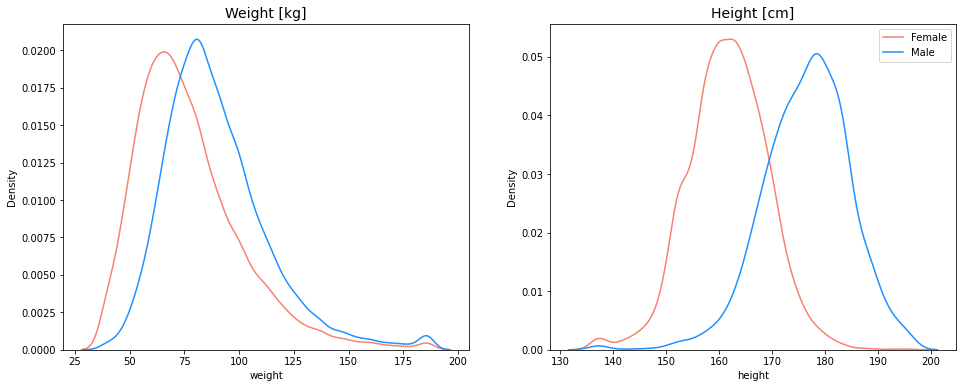

In [5]:
# Plot univariate or bivariate distributions using kernel density estimation.
# A kernel density estimate (KDE) plot is a method for visualizing the distribution of observations 
# in a dataset, analagous to a histogram. KDE represents the data using a continuous probability density 
# curve in one or more dimensions.

# some data exploration for the weight and height 
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

sns.kdeplot(X_train[X_train.gender == 'F'].weight, label='Female', color='salmon', ax=ax[0], bw_adjust=1.2)
sns.kdeplot(X_train[X_train.gender == 'M'].weight, label='Male', color='dodgerblue', ax=ax[0], bw_adjust=1.2)
ax[0].set_title('Weight [kg]', fontsize=14)
plt.legend()

sns.kdeplot(X_train[X_train.gender == 'F'].height, label='Female', color='salmon', ax=ax[1], bw_adjust=1.8)
sns.kdeplot(X_train[X_train.gender == 'M'].height, label='Male', color='dodgerblue', ax=ax[1], bw_adjust=2)
ax[1].set_title('Height [cm]', fontsize=14)
plt.legend()

plt.show()

In [6]:
lst = X_train.isna().sum() / len(X_train)

p = pd.DataFrame(lst)

# When we reset the index, the old index is added as a column, and a new sequential index is used
p.reset_index(inplace=True)

p.columns = ['a', 'b']
low_count = p[p['b'] > 0.3]

todelete = low_count['a'].values

X_train.drop(todelete, axis=1, inplace=True)
unlabeled.drop(todelete, axis=1, inplace=True)

X_train.shape

(91713, 108)

In [7]:
X_train.dropna(thresh=X_train.shape[1]*0.3, inplace=True)
X_train.shape

(91679, 108)

In [8]:
y_train = X_train['hospital_death']
X_train.drop('hospital_death', inplace=True, axis=1)

In [9]:
dictionary_ = pd.read_csv("WiDS Datathon 2020 Dictionary.csv")
print(dictionary_.shape)

(188, 6)


In [10]:
integer_cols = []
binary_cols = []
numeric_cols = []
string_cols = []

for i in range(dictionary_.shape[0]):
    if dictionary_.loc[i, 'Data Type'] == 'integer':
        integer_cols.append(dictionary_.loc[i, 'Variable Name'])

    if dictionary_.loc[i, 'Data Type'] == 'binary':
        binary_cols.append(dictionary_.loc[i, 'Variable Name'])

    if dictionary_.loc[i, 'Data Type'] == 'numeric':
        numeric_cols.append(dictionary_.loc[i, 'Variable Name'])

    if dictionary_.loc[i, 'Data Type'] == 'string':
        string_cols.append(dictionary_.loc[i, 'Variable Name'])

In [11]:
for col_name in string_cols:
    if col_name in X_train.columns.to_list():
        X_train[col_name].where(pd.notnull(X_train[col_name]), None, inplace=True)

    if col_name in unlabeled.columns.to_list():
        unlabeled[col_name].where(pd.notnull(unlabeled[col_name]), None, inplace=True)

In [12]:
from sklearn.preprocessing import OrdinalEncoder

enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)

for col_name in string_cols:
    if col_name in X_train.columns.to_list():
        X_train[col_name] = enc.fit_transform(X_train[[col_name]])

    if col_name in unlabeled.columns.to_list():
        unlabeled[col_name] = enc.fit_transform(unlabeled[[col_name]])

In [13]:
X_train = X_train.astype('float32')
unlabeled = unlabeled.astype('float32')

print(X_train.shape)
print(unlabeled.shape)

(91679, 107)
(39308, 107)


In [14]:
from sklearn.impute import KNNImputer

knn_imputer = KNNImputer(missing_values=np.nan, n_neighbors=5, weights='distance', 
metric='nan_euclidean', copy=False)

knn_imputer.fit(X_train)

KNNImputer(copy=False, weights='distance')

In [15]:
knn_imputer.transform(X_train)
knn_imputer.transform(unlabeled)

array([[2.0000000e+00, 5.6000000e+01, 2.1102440e+01, ..., 0.0000000e+00,
        7.0000000e+00, 4.0000000e+00],
       [5.0000000e+00, 6.1099613e+01, 1.9500595e+01, ..., 0.0000000e+00,
        7.0000000e+00, 4.0000000e+00],
       [7.0000000e+00, 6.6000000e+01, 3.2518597e+01, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [1.3103900e+05, 7.1000000e+01, 2.3010380e+01, ..., 1.0000000e+00,
        9.0000000e+00, 0.0000000e+00],
       [1.3104100e+05, 5.7000000e+01, 3.2987949e+01, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [1.3105000e+05, 6.6000000e+01, 2.3183392e+01, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00]], dtype=float32)

In [16]:
X_train.to_pickle("X_train.csv")
unlabeled.to_pickle("unlabeled_1.csv")
y_train.to_pickle("y_train.csv")

In [ ]:
X_train = pd.read_pickle("X_train.csv")
y_train = pd.read_pickle("y_train.csv")
unlabeled = pd.read_pickle("unlabeled_1.csv")

In [17]:
num_feature = []

for col_name in numeric_cols:
    if col_name in X_train.columns.to_list():
        num_feature.append(col_name)

In [18]:
# Create correlation matrix
corr_matrix = X_train[num_feature].corr().abs()

<AxesSubplot:>

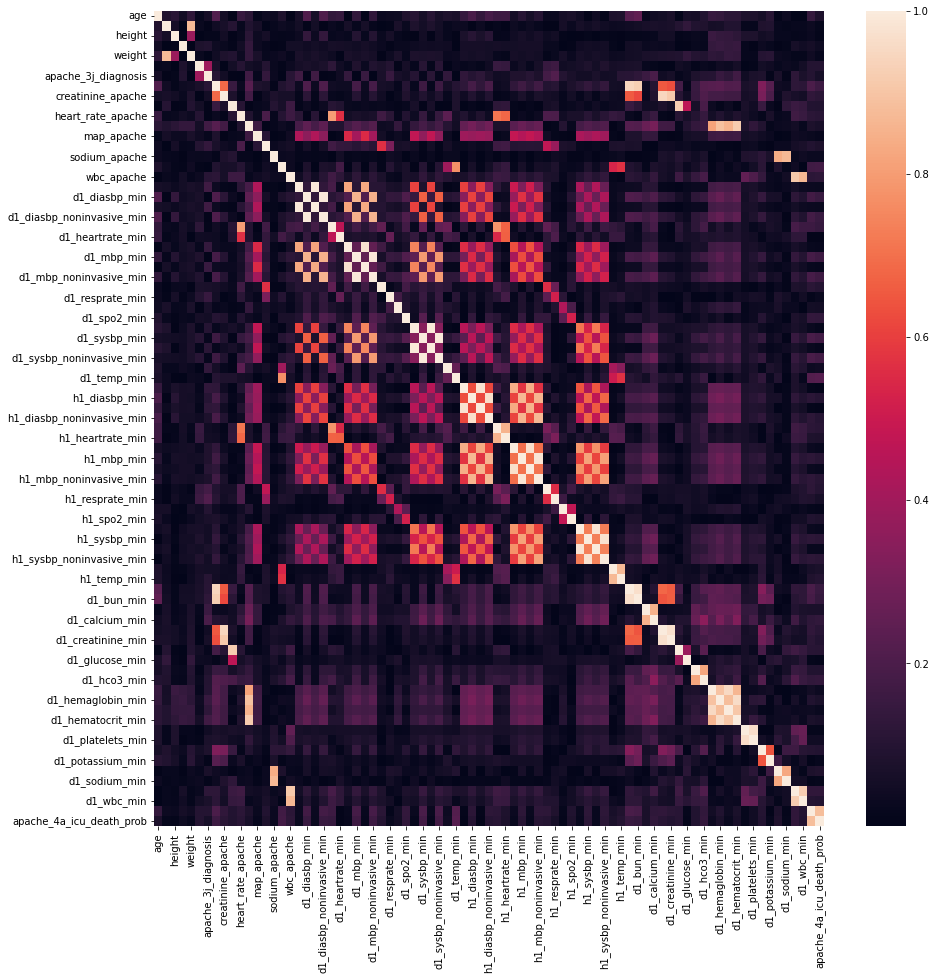

In [19]:
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(corr_matrix)

In [20]:
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

Text(0, 0.5, 'number of columns to drop')

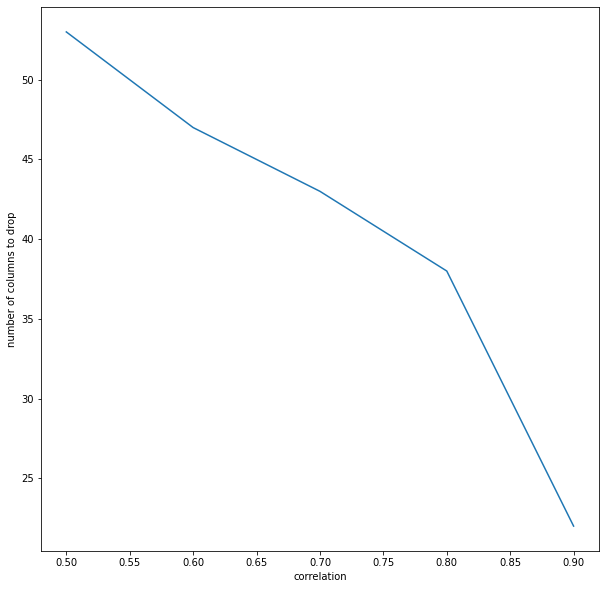

In [21]:
corr = []
to_drop_columns = []

for i in np.arange(0.5, 1, 0.1):
    to_drop = [column for column in upper.columns if any(upper[column] > i)]
    corr.append(i)
    to_drop_columns.append(len(to_drop))

plt.subplots(figsize=(10, 10))
plt.plot(corr, to_drop_columns)
plt.xlabel('correlation')
plt.ylabel('number of columns to drop')

In [22]:
# Find index of feature columns with correlation greater than 0.8
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]

X_train.drop(to_drop, inplace=True, axis=1)
unlabeled.drop(to_drop, inplace=True, axis=1)

print(X_train.shape)
print(unlabeled.shape)

(91679, 69)
(39308, 69)


In [23]:
from sklearn.ensemble import IsolationForest

iso = IsolationForest(n_estimators=1000, max_samples=500, contamination='auto', 
max_features=10, bootstrap=False, n_jobs=-1)

yhat = iso.fit_predict(X_train)

# select all rows that are not outliers
mask = yhat != -1

np.unique(mask, return_counts=True)

(array([False,  True]), array([ 2406, 89273], dtype=int64))

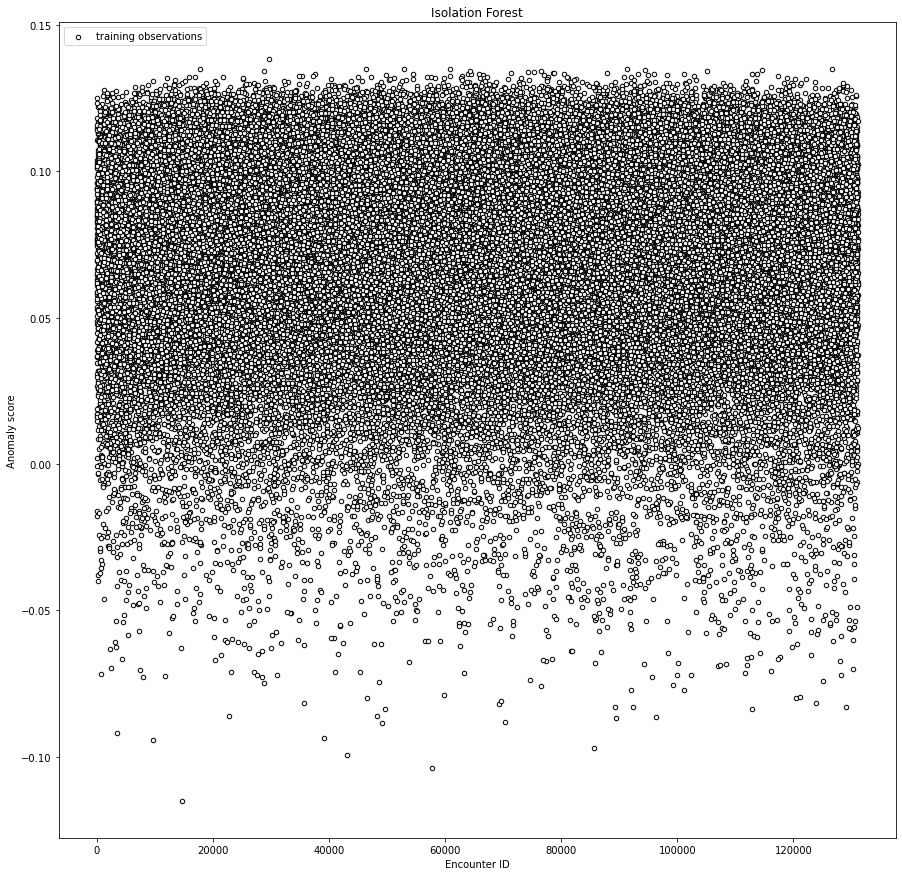

In [24]:
scores = iso.decision_function(X_train)

plt.subplots(figsize=(15, 15))
plt.title("Isolation Forest")

b = plt.scatter(X_train['encounter_id'], scores, c='white', s=20, edgecolor='k')

plt.axis('tight')
plt.legend([b], ["training observations"], loc="upper left")
plt.xlabel('Encounter ID')
plt.ylabel('Anomaly score')
plt.show()

In [25]:
X_train = X_train.loc[mask]
y_train = y_train.loc[mask]

In [26]:
from sklearn.preprocessing import MinMaxScaler

num_feature = []

for col_name in numeric_cols:
    if col_name in X_train.columns.to_list():
        num_feature.append(col_name)

scalar = MinMaxScaler()

scalar.fit(X_train[num_feature])

X_train[num_feature] = scalar.transform(X_train[num_feature])
unlabeled[num_feature] = scalar.transform(unlabeled[num_feature])

In [27]:
X_train.to_pickle("X_train.csv")
unlabeled.to_pickle("unlabeled_1.csv")
y_train.to_pickle("y_train.csv")

In [ ]:
X_train = pd.read_pickle("X_train.csv")
y_train = pd.read_pickle("y_train.csv")
unlabeled = pd.read_pickle("unlabeled_1.csv")

In [28]:
from sklearn.decomposition import PCA

X_train['hospital_death'] = y_train

pca = PCA()
components = pca.fit_transform(X_train)

for i, var in enumerate(pca.explained_variance_ratio_ * 100):
    print(f"PC {i+1} ({var:.1f}%)")

PC 1 (100.0%)
PC 2 (0.0%)
PC 3 (0.0%)
PC 4 (0.0%)
PC 5 (0.0%)
PC 6 (0.0%)
PC 7 (0.0%)
PC 8 (0.0%)
PC 9 (0.0%)
PC 10 (0.0%)
PC 11 (0.0%)
PC 12 (0.0%)
PC 13 (0.0%)
PC 14 (0.0%)
PC 15 (0.0%)
PC 16 (0.0%)
PC 17 (0.0%)
PC 18 (0.0%)
PC 19 (0.0%)
PC 20 (0.0%)
PC 21 (0.0%)
PC 22 (0.0%)
PC 23 (0.0%)
PC 24 (0.0%)
PC 25 (0.0%)
PC 26 (0.0%)
PC 27 (0.0%)
PC 28 (0.0%)
PC 29 (0.0%)
PC 30 (0.0%)
PC 31 (0.0%)
PC 32 (0.0%)
PC 33 (0.0%)
PC 34 (0.0%)
PC 35 (0.0%)
PC 36 (0.0%)
PC 37 (0.0%)
PC 38 (0.0%)
PC 39 (0.0%)
PC 40 (0.0%)
PC 41 (0.0%)
PC 42 (0.0%)
PC 43 (0.0%)
PC 44 (0.0%)
PC 45 (0.0%)
PC 46 (0.0%)
PC 47 (0.0%)
PC 48 (0.0%)
PC 49 (0.0%)
PC 50 (0.0%)
PC 51 (0.0%)
PC 52 (0.0%)
PC 53 (0.0%)
PC 54 (0.0%)
PC 55 (0.0%)
PC 56 (0.0%)
PC 57 (0.0%)
PC 58 (0.0%)
PC 59 (0.0%)
PC 60 (0.0%)
PC 61 (0.0%)
PC 62 (0.0%)
PC 63 (0.0%)
PC 64 (0.0%)
PC 65 (0.0%)
PC 66 (0.0%)
PC 67 (0.0%)
PC 68 (0.0%)
PC 69 (0.0%)
PC 70 (0.0%)


In [29]:
import plotly.express as px

fig = px.scatter(components, x=0, y=1, color=X_train['hospital_death'], width=1000, height=1000)
fig.show()

In [30]:
y_train = X_train['hospital_death']
X_train.drop('hospital_death', inplace=True, axis=1)

In [ ]:
from sklearn.covariance import EllipticEnvelope

ee = EllipticEnvelope(contamination=0.5)
yhat = ee.fit_predict(train)

mask = yhat != -1
len(mask)

In [ ]:
from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor(n_neighbors=50, contamination=.05)
outliers = lof.fit_predict(X_train)
mask = outliers != -1
np.unique(outliers, return_counts=True)

In [31]:
y_train.value_counts() / len(y_train)

0    0.926529
1    0.073471
Name: hospital_death, dtype: float64

In [32]:
cat_feature = []

for i, col_name in enumerate(X_train.columns.to_list()):
    if col_name not in numeric_cols:
        cat_feature.append(i)

In [33]:
from sklearn.model_selection import train_test_split

X_train1, X_train2, y_train1, y_train2 = train_test_split(X_train, y_train, test_size=0.5, stratify=y_train)
X_train11, X_train21, y_train11, y_train21 = train_test_split(X_train1, y_train1, test_size=0.5, 
stratify=y_train1)
X_train12, X_train22, y_train12, y_train22 = train_test_split(X_train2, y_train2, test_size=0.5, 
stratify=y_train2)

In [34]:
from imblearn.over_sampling import SMOTENC

sm = SMOTENC(categorical_features=cat_feature, n_jobs=-1)

X_train11, y_train11 = sm.fit_resample(X_train11, y_train11)

In [35]:
X_train21, y_train21 = sm.fit_resample(X_train21, y_train21)

In [36]:
X_train12, y_train12 = sm.fit_resample(X_train12, y_train12)

In [37]:
X_train22, y_train22 = sm.fit_resample(X_train22, y_train22)

In [38]:
print(y_train11.value_counts() / len(y_train11))
print(y_train21.value_counts() / len(y_train21))
print(y_train12.value_counts() / len(y_train12))
print(y_train22.value_counts() / len(y_train22))

0    0.5
1    0.5
Name: hospital_death, dtype: float64
0    0.5
1    0.5
Name: hospital_death, dtype: float64
0    0.5
1    0.5
Name: hospital_death, dtype: float64
0    0.5
1    0.5
Name: hospital_death, dtype: float64


In [39]:
X_train = pd.concat([X_train11, X_train21, X_train12, X_train22])
y_train = pd.concat([y_train11, y_train21, y_train12, y_train22])

print(X_train.shape)
print(y_train.shape)

(165428, 69)
(165428,)


In [40]:
X_train.to_pickle("X_train.csv")
unlabeled.to_pickle("unlabeled_1.csv")
y_train.to_pickle("y_train.csv")

In [ ]:
X_train = pd.read_pickle("X_train.csv")
y_train = pd.read_pickle("y_train.csv")
unlabeled = pd.read_pickle("unlabeled_1.csv")

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from metric_learn import NCA

lf = NCA(n_components=2)
chosen_idx = np.random.choice(159001, size=1000)
X_metric = X_train.iloc[chosen_idx, :]
y_metric = y_train.iloc[chosen_idx]
lf.fit(X_metric, y_metric)
X_transformed = lf.transform(X_metric)
#print(X_transformed)

[0 1]


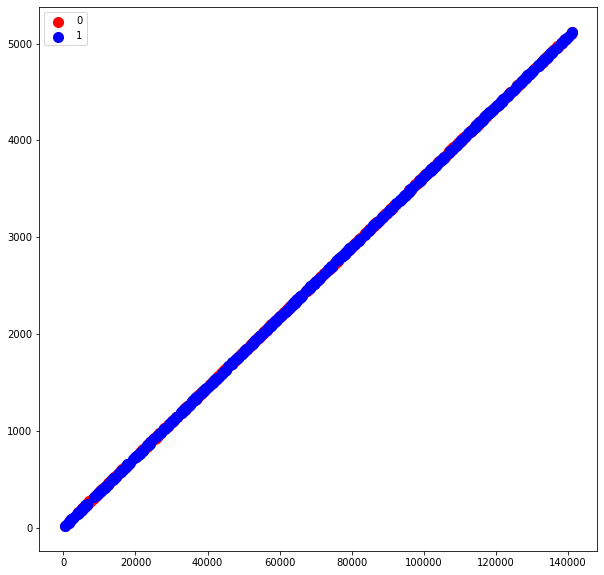

In [42]:
cdict = {0: 'red', 1: 'blue'}
fig, ax = plt.subplots(figsize=(10,10))
print(np.unique(y_metric))

for g in np.unique(y_metric):
    ix = np.where(y_metric == g)
    ax.scatter(X_transformed[ix,0], X_transformed[ix,1], c = cdict[g], label = g, s = 100)
ax.legend()
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, stratify=y_train)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=1000, max_depth=None, min_samples_split=50, 
max_features='auto', bootstrap=True, n_jobs=-1, random_state=20)

rf.fit(X_train, y_train)

sorted_idx = rf.feature_importances_.argsort()

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 18))
plt.barh(X_train.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

In [ ]:
from sklearn.metrics import accuracy_score

pred = rf.predict(X_test)
print(f"accuracy score voting is {accuracy_score(y_test, pred)}")

In [ ]:
prob = rf.predict_proba(unlabeled)[:,1]

submission = pd.DataFrame({'encounter_id': unlabeled['encounter_id'].astype(int), 'hospital_death': prob})

print(len(prob))
print(len(unlabeled['encounter_id']))

In [ ]:
submission.to_csv("submission.csv", index=False)